In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


# 1. Importing Data

In [2]:
customers =pd.read_excel("E-commerce_data.xlsx", sheet_name= 'customers' )
genders=pd.read_excel("E-commerce_data.xlsx", sheet_name= 'genders')
cities = pd.read_excel("E-commerce_data.xlsx", sheet_name= 'cities')
transactions = pd.read_excel("E-commerce_data.xlsx", sheet_name='transactions')
branches = pd.read_excel("E-commerce_data.xlsx", sheet_name= 'branches')
merchants = pd.read_excel("E-commerce_data.xlsx",sheet_name= 'merchants')

## 2. Merging Tables

In [3]:
# Merge Customers with Cities and Genders to get demographic information
customers_with_demo = customers.merge(cities, on='city_id', how='left').merge(genders, on='gender_id', how='left')

# Merge Transactions with Customers (with demographic data)
transactions_with_customers = transactions.merge(customers_with_demo, on='customer_id', how='left')

# Calculate features for each customer:
# 1. Number of transactions per customer
# 2. Number of coupons burnt vs claimed
# 3. Time since last transaction (recency)

# Total number of transactions per customer
transaction_count = transactions_with_customers.groupby('customer_id').size().reset_index(name='transaction_count')

# Number of burnt coupons
burned_coupons = transactions_with_customers[transactions_with_customers['transaction_status'] == 'burned'].groupby('customer_id').size().reset_index(name='burned_count')

# Recency - difference between max date and the last transaction date
today = pd.to_datetime("2024-07-15")
recency = transactions_with_customers.groupby('customer_id')['transaction_date'].max().reset_index()
recency['recency_days'] = (today - recency['transaction_date']).dt.days

# Merge these new features with the customer demographic information
customer_features = customers_with_demo.merge(transaction_count, on='customer_id', how='left') \
                                       .merge(burned_coupons, on='customer_id', how='left') \
                                       .merge(recency[['customer_id', 'recency_days']], on='customer_id', how='left')

# Fill missing values (for customers with no burned coupons)
customer_features['burned_count'] = customer_features['burned_count'].fillna(0)

# Show the first few rows of the final dataset with selected features
customer_features.head()


,customer_id,join_date,city_id,gender_id,city_name,gender_name,transaction_count,burned_count,recency_days
0,1,2022-01-08,7,1,Mansoura,Male,7.0,3.0,50.0
1,2,2023-05-02,20,2,Sohag,Female,3.0,1.0,268.0
2,3,2023-05-14,15,1,Aswan,Male,5.0,1.0,10.0
3,4,2022-11-25,11,2,Ismailia,Female,1.0,0.0,547.0
4,5,2023-04-26,8,1,El-Mahalla El-Kubra,Male,4.0,3.0,13.0


## 3. Feature Engineering

In [4]:
# Select features for clustering
features = customer_features[['transaction_count', 'burned_count', 'recency_days']]

features.isna()
# Display rows with missing values (NA)
na_rows = features[features.isna().any(axis=1)]

# Show the rows with NA values
print(na_rows)


     transaction_count  burned_count  recency_days
8                  NaN           0.0           NaN
33                 NaN           0.0           NaN
36                 NaN           0.0           NaN
345                NaN           0.0           NaN
409                NaN           0.0           NaN
544                NaN           0.0           NaN
696                NaN           0.0           NaN
704                NaN           0.0           NaN
705                NaN           0.0           NaN
878                NaN           0.0           NaN
966                NaN           0.0           NaN


## 4. Handling Missing Data

In [17]:
# First, fill missing recency values with max recency
max_recency = features['recency_days'].max()
features['recency_days'] = features['recency_days'].fillna(max_recency)

# Then, fill remaining missing values (if any) in other columns with 0
features_filled = features.fillna(0)

# Check if any missing values remain
features_filled.isna().sum()

transaction_count    0
burned_count         0
recency_days         0
dtype: int64

## 5. K-Means Clustering

In [6]:
# Apply K-Means clustering with a range of clusters
kmeans_models = {}

 # Trying different numbers of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_filled)
kmeans

KMeans(n_clusters=3, random_state=42)

In [23]:
# Access cluster centers
cluster_centers = kmeans.cluster_centers_

# Convert to DataFrame for easier interpretation
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numeric_columns)

print(cluster_centers_df)


   transaction_count  burned_count  recency_days
0           3.853801      2.052632    324.204678
1           5.341975      2.665432     54.407407
2           0.736842      0.315789    917.210526


In [18]:
# Assign cluster labels to the customer features
customer_features['cluster'] = kmeans.labels_

# Select relevant numeric columns
numeric_columns = ['transaction_count', 'burned_count', 'recency_days']

# Group by cluster and calculate the mean for these columns
cluster_summary = customer_features.groupby('cluster')[numeric_columns].mean()

# Display the summary of clusters
print(cluster_summary)

         transaction_count  burned_count  recency_days
cluster                                               
0                 3.853801      2.052632    324.204678
1                 5.341975      2.665432     54.407407
2                 1.750000      0.315789    780.000000


In [19]:
# If you want to include all numeric columns in a separate summary
numeric_data = customer_features.select_dtypes(include='number')
full_cluster_summary = numeric_data.groupby(customer_features['cluster']).mean()

# Print the full summary
print(full_cluster_summary)


         customer_id    city_id  gender_id  transaction_count  burned_count  \
cluster                                                                       
0         466.432749  10.415205   1.485380           3.853801      2.052632   
1         508.812346  10.053086   1.492593           5.341975      2.665432   
2         452.736842  11.157895   1.473684           1.750000      0.315789   

         recency_days  cluster  
cluster                         
0          324.204678      0.0  
1           54.407407      1.0  
2          780.000000      2.0  


In [12]:
for cluster in range(3):
    print(f"\nCluster {cluster} Summary:")
    print(customer_features[customer_features['cluster'] == cluster].describe())



Cluster 0 Summary:
       customer_id                      join_date     city_id   gender_id  \
count   171.000000                            171  171.000000  171.000000   
mean    466.432749  2022-04-26 01:41:03.157894656   10.415205    1.485380   
min       2.000000            2021-07-21 00:00:00    1.000000    1.000000   
25%     194.000000            2021-11-25 12:00:00    5.000000    1.000000   
50%     456.000000            2022-04-07 00:00:00   10.000000    1.000000   
75%     743.500000            2022-08-13 12:00:00   16.000000    2.000000   
max     991.000000            2023-12-25 00:00:00   20.000000    2.000000   
std     303.793854                            NaN    5.946586    0.501254   

       transaction_count  burned_count  recency_days  cluster  
count         171.000000    171.000000    171.000000    171.0  
mean            3.853801      2.052632    324.204678      0.0  
min             1.000000      0.000000    190.000000      0.0  
25%             2.000000      

## 6. Silhouette Score

In [13]:
score = silhouette_score(features_filled, customer_features['cluster'])
print("Silhouette Score:", score)


Silhouette Score: 0.7215931726015354


## 7. Visualizations

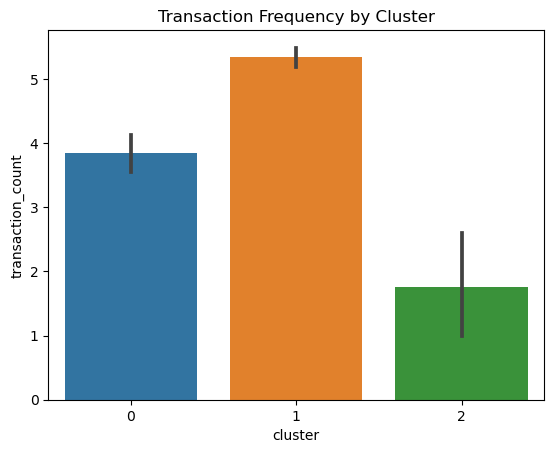

In [14]:

sns.barplot(x='cluster', y='transaction_count', data=customer_features)
plt.title('Transaction Frequency by Cluster')
plt.show()


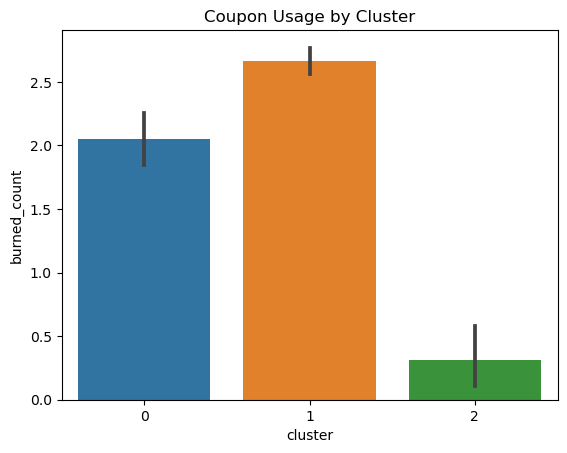

In [15]:
sns.barplot(x='cluster', y='burned_count', data=customer_features)
plt.title('Coupon Usage by Cluster')
plt.show()


Cluster 0: High transactions, frequent coupon redemption, recent activity

    Description: These are your most active and loyal customers, redeeming coupons frequently.
    Recommendation: Offer exclusive deals or rewards for loyalty to maintain satisfaction.

Cluster 1: Moderate transactions, some coupon use, long time since last purchase

    Description: Previously active customers who haven’t transacted in a while.
    Recommendation: Send reactivation offers to encourage them to return.

Cluster 2: Low transactions, rare coupon use, moderate recency

    Description: Low-value customers with fewer transactions.
    Recommendation: Offer attractive discounts to motivate higher engagement.

## 6. PCA for Visualization

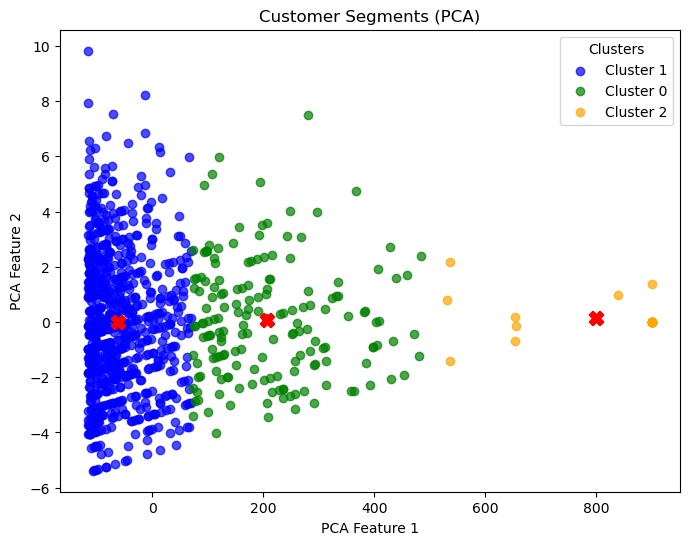

In [16]:
# Perform PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_filled)
centroids = pca.transform(kmeans.cluster_centers_)


# Create a scatter plot with legend
plt.figure(figsize=(8, 6))

# Plot each cluster separately with different labels
clusters = customer_features['cluster'].unique()  # Get unique clusters
colors = ['blue', 'green', 'orange']  # Define colors for each cluster

for cluster, color in zip(clusters, colors):
    cluster_points = pca_features[customer_features['cluster'] == cluster]  # Filter points by cluster
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', color=color, alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')


# Add title and labels
plt.title('Customer Segments (PCA)')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')

# Add legend to the plot
plt.legend(title="Clusters")

# Display the plot
plt.show()
